In [1]:
import nibabel as nib
import numpy as np
from skimage import exposure

In [147]:
import SimpleITK as sitk
import numpy as np

def _mm_to_radius(mm, spacing):
    return [max(1, int(round(mm / s))) for s in spacing]

def skull_strip_ncct(ncct_path, out_mask_path, out_ncct_stripped=None,
                     clamp=(-100, 200), soft_range=(-15, 100),
                     close_mm=3.0, erode_mm=3.0,
                     skull_hu=250, shave_mm=1.5):
    img = sitk.ReadImage(ncct_path)
    sp = img.GetSpacing()

    # 1) clamp + soft-tissue threshold
    clamped = sitk.Clamp(img, lowerBound=clamp[0], upperBound=clamp[1])
    soft = sitk.BinaryThreshold(clamped, lowerThreshold=soft_range[0], upperThreshold=soft_range[1],
                                insideValue=1, outsideValue=0)

    # 2) clean mask
    soft = sitk.BinaryMorphologicalClosing(soft, _mm_to_radius(close_mm, sp))
    soft = sitk.VotingBinaryIterativeHoleFilling(soft, radius=_mm_to_radius(2.0, sp),
                                                 majorityThreshold=1,
                                                 backgroundValue=0, foregroundValue=1,
                                                 maximumNumberOfIterations=1)

    # 3) largest component = brain
    cc = sitk.ConnectedComponent(soft)
    stats = sitk.LabelShapeStatisticsImageFilter(); stats.Execute(cc)
    largest = max(stats.GetLabels(), key=lambda l: stats.GetPhysicalSize(l))
    brain = sitk.BinaryThreshold(cc, lowerThreshold=largest, upperThreshold=largest,
                                 insideValue=1, outsideValue=0)

    # 4) shave inner skull: detect hard bone on original image, dilate inward, subtract
    skull = sitk.BinaryThreshold(img, lowerThreshold=skull_hu, upperThreshold=3000,
                                 insideValue=1, outsideValue=0)
    skull_inner = sitk.BinaryDilate(skull, _mm_to_radius(shave_mm, sp))
    brain = sitk.And(brain, sitk.BinaryNot(skull_inner))

    # 5) light erosion to smooth rim + re-close + keep largest again
    brain = sitk.BinaryErode(brain, _mm_to_radius(erode_mm, sp))
    brain = sitk.BinaryMorphologicalClosing(brain, _mm_to_radius(2.0, sp))
    cc2 = sitk.ConnectedComponent(brain)
    stats2 = sitk.LabelShapeStatisticsImageFilter(); stats2.Execute(cc2)
    largest2 = max(stats2.GetLabels(), key=lambda l: stats2.GetPhysicalSize(l))
    brain = sitk.BinaryThreshold(cc2, lowerThreshold=largest2, upperThreshold=largest2,
                                 insideValue=1, outsideValue=0)
    brain = sitk.Cast(brain, sitk.sitkUInt8)

    sitk.WriteImage(brain, out_mask_path)
    if out_ncct_stripped:
        sitk.WriteImage(sitk.Mask(img, brain), out_ncct_stripped)

In [148]:
skull_strip_ncct(
    ncct_path="/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0004/ses-01/sub-stroke0004_ses-01_space-ncct_cta.nii.gz",
    out_mask_path="/home/stud/sazidur/bhome/ELE670_project/scripts/sub-stroke0004_ses-01_brain-msk.nii.gz",
    out_ncct_stripped="/home/stud/sazidur/bhome/ELE670_project/scripts/sub-stroke0004_ses-01_cta-stripped.nii.gz"
)


In [192]:
file_path = "/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset010_ISLES24_multi/imagesTr/case_0004_0000.nii.gz"

In [193]:
img = nib.load(file_path)
data = img.get_fdata()
print("Original shape:", data.shape)

Original shape: (512, 587, 69)


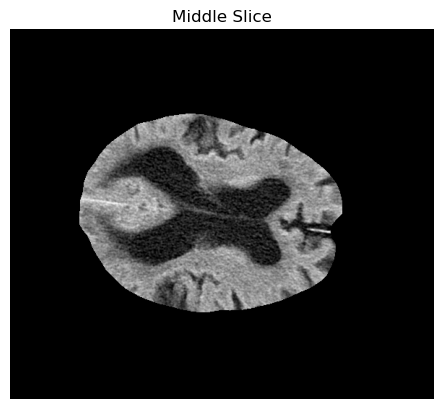

In [194]:
import matplotlib.pyplot as plt
plt.imshow(data[:, :, data.shape[2] // 2],cmap='gray')
plt.title('Middle Slice')
plt.axis('off')
plt.show()

In [171]:
# Clip the data to the custom intensity range
mask= nib.load("/home/stud/sazidur/bhome/ELE670_project/scripts/sub-stroke0004_ses-01_brain-msk.nii.gz").get_fdata() > 0
min_intensity = 0
max_intensity = 90
data_clipped = np.clip(data, min_intensity, max_intensity)
data_clipped[~mask] = 0
data_clipped[data == 0] = 0
    # Normalize the data to [0, 1] range
data_clipped[data_clipped > 0.0001] -= min_intensity
data_normalized = data_clipped / (max_intensity - min_intensity)

    # Apply 3D histogram equalization
equalized_data = exposure.equalize_hist(data_normalized, mask=(data_normalized > 0.0001))
    
equalized_data[data_normalized < 0.0001] = 0
     
    # Save the result as a new NIfTI file
equalized_img = nib.Nifti1Image(equalized_data, img.affine, img.header)

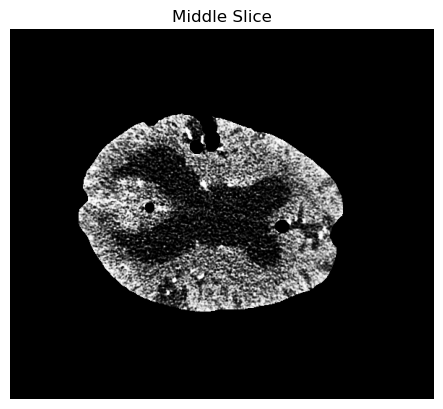

In [172]:
import matplotlib.pyplot as plt
plt.imshow(equalized_img.get_fdata()[:, :, equalized_img.shape[2] // 2],cmap='gray')
plt.title('Middle Slice')
plt.axis('off')
plt.show()

### PREDICTION

In [1]:
import nibabel as nib
import numpy as np
from skimage import exposure

In [40]:
pat = nib.load("/home/stud/sazidur/bhome/ELE670_project/nnUNetFrame/dataset/nnUNet_raw/Dataset010_ISLES24_multi/imagesTs/case_0158_0005.nii.gz")
pred = nib.load("/home/stud/sazidur/bhome/ELE670_project/preds_010_fullres/case_0158.nii.gz")
gt = nib.load("/home/stud/sazidur/bhome/test/isles24_train-1/derivatives/sub-stroke0158/ses-02/sub-stroke0158_ses-02_lesion-msk.nii.gz")

In [41]:
pat.shape

(512, 512, 101)

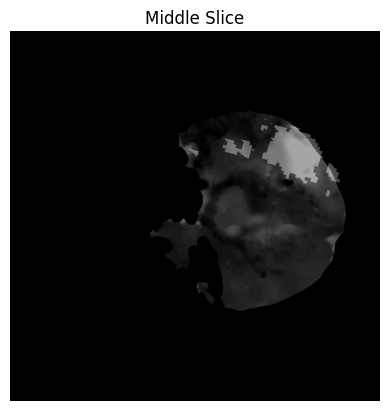

In [44]:
import matplotlib.pyplot as plt
plt.imshow(pat.get_fdata()[:, :, pat.shape[2] // 2],cmap='gray')
plt.imshow(pred.get_fdata()[:, :, pred.shape[2] // 2],cmap='gray', alpha=0.5)
plt.imshow(gt.get_fdata()[:, :, pred.shape[2] // 2],cmap='gray', alpha=0.3)
plt.title('Middle Slice')
plt.axis('off')
plt.show()